In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.integrate as integrate
from tqdm import tqdm
import statistics
import corner

In [118]:
data_dl  = np.array([0, 5085.7516])

delta_dl = np.array([1e-14, 63.571895])

data_z   = np.array([0,0.8])

Text(0.5, 0, '$z$')

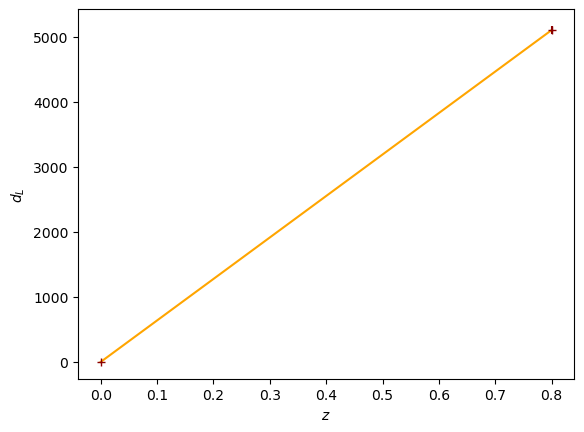

In [192]:
plt.plot(data_z,data_dl, color="orange")
plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

In [193]:
def llike(data_dl, data_z, H0_prop, delta_dl, N_obs):

    c = 3e5
    omega = 0.274

    func = 1/(np.sqrt(omega*((data_z+1)**3)+1-omega))
    
    integ = integrate.cumtrapz(func, data_z, initial = 0) 
    
    init_point = 0.5*0*(func[0] + 1)
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - ((c/H0_prop)*((1+data_z)*(integ + init_point))))**2)
    

    return(first_term + second_term)

In [194]:
def lprior_uniform(param, param_low_val, param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

In [195]:
def lpost(data_dl, data_z, H0_prop, delta_dl, N_obs, param1, param1_low_range = 30, param1_high_range = 100):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param1, param1_low_range, param1_high_range) 
           + llike(data_dl, data_z, H0_prop, delta_dl, N_obs))

In [196]:
def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

In [197]:
def MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs, param_start, H0_var_prop, printerval):
    '''
    Metropolis MCMC sampler
    '''

    # Set starting values

    H0_chain = [param_start[0]]
                                           
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_dl, data_z, H0_chain[0], delta_dl, N_obs, H0_chain[0])) # Append first value of log posterior 
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        
        if i % printerval == 0: # Print accept/reject ratio.
            # tqdm.write("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            accept_reject_ratio = sum(accept_reject_count)/len(accept_reject_count)
            tqdm.write("Iteration {0}, accept_reject = {1}".format(i,accept_reject_ratio))
            # print("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 

        H0_prop = np.random.normal(H0_chain[i - 1], np.sqrt(H0_var_prop))
    
        # Compute log posterior
        lp_prop = lpost(data_dl, data_z, H0_prop, delta_dl, N_obs, H0_prop)
        
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            H0_chain.append(H0_prop)    # accept H0_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
            
        else:  # Reject, if this is the case we use previously accepted values
            H0_chain.append(H0_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as np.arrays
    H0_chain = np.array(H0_chain)
    H0_chain = H0_chain[burnin:]

    
    return H0_chain, lp  # Return chains and log posterior.

In [202]:
param_start =[60]
Ntotal = 100000 # Total number of iterations
burnin = 30000  # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters
H0_var_prop = 0.8743905288970055
printerval = 50000

N_obs = len(data_z)

In [203]:
H0_chain, lp = MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs,
                           param_start, H0_var_prop, printerval)

 52%|██████████████████▏                | 51833/99999 [00:06<00:05, 8558.73it/s]

Iteration 50000, accept_reject = 0.68858


100%|███████████████████████████████████| 99999/99999 [00:11<00:00, 8565.76it/s]


In [204]:
len(H0_chain)

70000

mean of H0 = 70.14608394073623 _ standard deviation of H0 = 0.8768553636350244


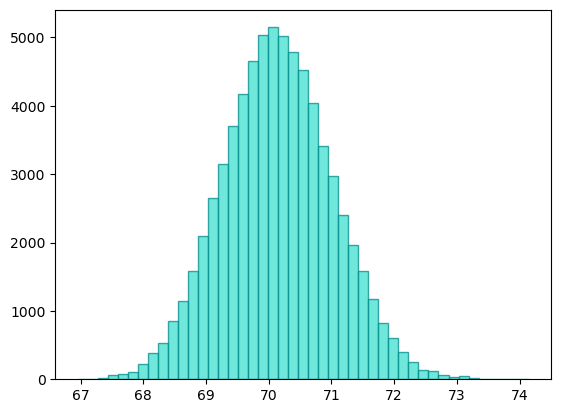

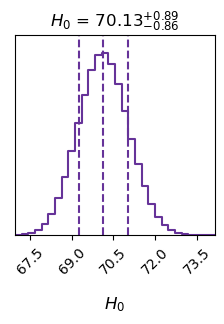

In [205]:
plt.hist(H0_chain, bins = 45, color = 'turquoise', edgecolor = 'darkcyan', alpha = 0.75)

ma = statistics.mean(H0_chain)
sda = statistics.stdev(H0_chain)

print("mean of H0 =", ma, '_', "standard deviation of H0 =", sda)

samples = np.column_stack([H0_chain])

params = [r"$H_0$"]

figure = corner.corner(samples, bins = 30, color = 'rebeccapurple', labels = params, 
                plot_datapoints = True, smooth1d = True, smooth = True, quantiles=[0.16, 0.5, 0.84],
                show_titles = True, label_kwargs = {"fontsize":12}, title_fmt='.2f',title_kwargs={"fontsize": 12})

In [156]:
from astropy.cosmology import FlatLambdaCDM
>>> cosmo = FlatLambdaCDM(H0=70, Om0=0.274)


In [157]:
cosmo.luminosity_distance(0.8)  

<Quantity 5085.75157009 Mpc>

In [161]:
5085.7516/50

101.715032

In [189]:
5085.7516/80

63.571895